In [1]:
# Code to preprocessing outcome data, imaging features, then create predictions based on the features
# outputs include: predicted models, accuracies, feature importance, table 1 basic distributions with outcome
# Setup, imports
import math
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
from IPython.display import SVG
from tableone import TableOne
from IPython.display import HTML

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn import preprocessing, decomposition, svm
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, roc_auc_score,  ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier,  export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import auc 
from sklearn.metrics import RocCurveDisplay

import catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 106)

# Helper functions

In [2]:
#feature selection
#dropping high VIF columns
def calculate_vif(X, thresh=15):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
            
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

def VIF_feature_select(data, name, id_col_name = 'filename', feature_select = 1):
    
    #if there is a filename column, we will remove it and add it back later.
    #if no filename column, ignore
    imNameFlag = 0
    if id_col_name in data.columns:
        dataTemp = data
        data = data.drop(columns=[id_col_name])
        imNameFlag = 1
        
    csvName = 'dataFiltered_' + name + '.csv'
    
    if(os.path.isfile(csvName)):
        dataFiltered = pd.read_csv(csvName)
        return dataFiltered
    else:
        if (feature_select == 0):
            return data

        dataFiltered = calculate_vif(data, 10)
        
        if (imNameFlag == 1):
            dataFiltered[id_col_name] = dataTemp[id_col_name]

        #saving feature selected data
        dataFiltered.to_csv(csvName, index = False)

        return dataFiltered

In [3]:
#data imports and preprocessing
data_radiomics_raw = pd.read_csv('radiomics_old.csv',engine='python')
data_outcomes_raw = pd.read_csv('segmentation_labels_mgfr_cls.csv',engine='python')

#joining both by ID, but have to edit the ID columns because they are labelled differently

data_outcomes_raw['filename'] = data_outcomes_raw['filename'].str.replace('.png', '', regex=False)
data_radiomics_raw['imName'] = data_radiomics_raw['imName'].str.split('_').str[:-1].str.join('_')

#removing useless columbs
data_radiomics_raw = data_radiomics_raw.drop('maskNum', axis=1)
data_outcomes_raw = data_outcomes_raw.drop_duplicates(subset = 'filename', keep = 'first')

# binary mapping of outcomes and file labels
data_outcomes_raw['mgfr_cls_flag'] = data_outcomes_raw['mgfr_cls'].map({'Normal': 0, 'Kidney_Disease': 1})
data_outcomes_raw['file_attributes_flag'] = data_outcomes_raw['file_attributes'].apply(
    lambda x: 0 if 'Normal' in x else (1 if 'Abnormal' in x else None)
)


data_outcomes_raw_filtered = data_outcomes_raw[['filename', 'file_attributes_flag', 'mgfr', 'mgfr_cls_flag']]
data_outcomes_raw_filtered

data_all = pd.merge(
    data_outcomes_raw_filtered,
    data_radiomics_raw,
    left_on='filename',
    right_on='imName',
    how='inner'  # use 'outer', 'left', or 'right' if needed
)

data_all = data_all.drop('imName', axis=1)
data_all.to_csv("data_cleaned.csv")
data_all

filename  file_attributes_flag        mgfr  \
0            1__Still images_IM-0001-0020                     0  201.050000   
1            1__Still images_IM-0001-0040                     0  201.050000   
2            2__Still Images_IM-0001-0016                     0  151.580000   
3            2__Still Images_IM-0001-0062                     1  151.580000   
4       3__still_images_5384_IM-0001-0031                     0   40.830000   
..                                    ...                   ...         ...   
689  365a__Still_images_5346_IM-0002-0033                     1   30.251345   
690  365a__Still_images_5346_IM-0002-0049                     1   30.251345   
691  383a__Still_images_5375_IM-0001-0006                     0   41.953214   
692  383b__Still_images_5379_IM-0001-0031                     0   41.953214   
693   385__Still_images_5366_IM-0001-0004                     0   63.131209   

     mgfr_cls_flag  original_shape2D_Elongation  \
0                0                     0.349595   
1                0                     0.417717   
2                0                     0.346946   
3                0                     0.473713   
4                1                     0.092461   
..             ...                          ...   
689              1                     0.484504   
690              1                     0.422497   
691              1                     0.524145   
692              1                     0.534737   
693              0                     0.378253   

     original_shape2D_MajorAxisLength  original_shape2D_MaximumDiameter  \
0                         1622.958220                       1180.034745   
1                         1905.351612                       1404.624505   
2                         2116.748882                       1583.480344   
3                         2323.803551                       1779.031759   
4                         1587.460963                       1385.428814   
..                                ...                               ...   
689                       1478.479063                       1019.656805   
690                       1592.250172                       1176.384291   
691                        764.781866                        558.649264   
692                        755.302919                        561.381332   
693                        788.520539                        596.969011   

     original_shape2D_MeshSurface  original_shape2D_MinorAxisLength  \
0                        107203.0                        567.378098   
1                        130856.5                        795.898301   
2                        160310.5                        734.396706   
3                        159973.0                       1100.815160   
4                        129115.5                        146.777456   
..                            ...                               ...   
689                      104768.5                        716.328636   
690                      143944.5                        672.720618   
691                       25410.5                        400.856796   
692                       25080.0                        403.888608   
693                       17338.0                        298.260008   

     original_shape2D_Perimeter  ...  \
0                   4257.947761  ...   
1                   5198.174383  ...   
2                   5086.256418  ...   
3                   5417.976331  ...   
4                   3112.052957  ...   
..                          ...  ...   
689                 4424.487732  ...   
690                 4502.239174  ...   
691                 2461.336362  ...   
692                 2494.182033  ...   
693                 2035.550432  ...   

     original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                         1.095314   
1                                         0.260777   
2                                         1.376564   
3                   

In [6]:
# basic stats
data_table1 = data_all.drop('filename', axis=1)
table1_columns = data_table1.columns.tolist()
table1_binary = TableOne(data_table1, columns=table1_columns, pval = True, 
                       groupby = ['mgfr_cls_flag'], htest_name=True, smd=True)
table1_binary

Grouped by mgfr_cls_flag                                                                                                                      
                                                                                 Missing                    Overall                          0                          1 P-Value               Test SMD (0,1)
n                                                                                                               694                        504                        190                                     
file_attributes_flag, n (%)                                   0                        0                 545 (78.5)                 437 (86.7)                 108 (56.8)  <0.001        Chi-squared     0.703
                                                              1                                          149 (21.5)                  67 (13.3)                  82 (43.2)                                     
mgfr, mean (SD)                                                                        0               120.2 (49.3)               141.4 (39.2)                63.8 (20.7)  <0.001  Two Sample T-test    -2.479
original_shape2D_Elongation, mean (SD)                                                 0                  0.4 (0.1)                  0.4 (0.1)                  0.4 (0.1)   0.061  Two Sample T-test    -0.163
original_shape2D_MajorAxisLength, mean (SD)                                            0             1610.8 (685.5)             1672.9 (670.7)             1446.1 (698.7)  <0.001  Two Sample T-test    -0.331
original_shape2D_MaximumDiameter, mean (SD)                                            0             1189.9 (505.1)             1236.7 (493.3)             1066.0 (516.2)  <0.001  Two Sample T-test    -0.338
original_shape2D_MeshSurface, mean (SD)                                                0         117288.8 (81163.5)         124602.5 (81119.3)          97888.2 (78233.3)  <0.001  Two Sample T-test    -0.335
original_shape2D_MinorAxisLength, mean (SD)                                            0              690.6 (322.5)              722.1 (319.1)              606.9 (317.1)  <0.001  Two Sample T-test    -0.362
original_shape2D_Perimeter, mean (SD)                                                  0            4701.7 (2075.1)            4901.5 (2028.6)            4171.8 (2109.0)  <0.001  Two Sample T-test    -0.353
original_shape2D_PerimeterSurfaceRatio, mean (SD)                                      0                  0.1 (0.1)                  0.1 (0.0)                  0.1 (0.1)   0.001  Two Sample T-test     0.311
original_shape2D_PixelSurface, mean (SD)                                               0         117289.4 (81163.4)         124603.1 (81119.2)          97888.8 (78233.3)  <0.001  Two Sample T-test    -0.335
original_shape2D_Sphericity, mean (SD)                                                 0                  0.2 (0.0)                  0.2 (0.0)                  0.2 (0.0)   0.635  Two Sample T-test     0.042
original_firstorder_10Percentile, mean (SD)                                            0                15.7 (15.1)                14.8 (14.5)                18.1 (16.4)   0.016  Two Sample T-test     0.212
original_firstorder_90Percentile, mean (SD)                                            0                64.5 (21.6)                61.6 (20.8)                72.4 (22.0)  <0.001  Two Sample T-test     0.507
original_firstorder_Energy, mean (SD)                                                  0  198560961.6 (183237054.5)  195498482.3 (175445411.2)  206684591.1 (202731178.2)   0.502  Two Sample T-test     0.059
original_firstorder_Entropy, mean (SD)                                                 0                  1.5 (0.4)                  1.5 (0.4)                  1.7 (0.4)  <0.001  Two Sample T-test     0.483
original_firstorder_InterquartileRange, mean (SD)                                      0                25.8 (10.1)                

In [44]:
# Feature selection
# Approx n = 350, so max 30-35 featutres
# First will do VIF to remove collinears, then mutual info score selection

#dropping outcome columns and the manual abnormal labels before feature selecting
cols_labels = ['mgfr', 'mgfr_cls_flag','file_attributes_flag']
data_no_labels = data_all.drop(columns = cols_labels)
data_labels_only = data_all[['filename'] + cols_labels]
data_VIF_no_labels = VIF_feature_select(data_no_labels, 'data_all', 
                                     'filename', feature_select = 1)
data_VIF_no_labels

original_firstorder_10Percentile  original_firstorder_Kurtosis  \
0                                 4.0                     13.376776   
1                                12.0                      3.405356   
2                                 0.0                     16.138137   
3                                 7.0                      3.813743   
4                                17.0                      2.712345   
..                                ...                           ...   
689                              25.0                      2.994076   
690                              20.0                      2.710040   
691                              10.0                      3.931123   
692                               0.0                      2.864715   
693                              18.0                      2.413223   

     original_firstorder_Minimum  original_firstorder_TotalEnergy  \
0                              0                         90659144   
1                              0                        105680551   
2                              0                        184878121   
3                              0                        128170438   
4                              0                        229767002   
..                           ...                              ...   
689                            0                        300490843   
690                            0                        225745526   
691                            0                         55222386   
692                            0                         55410325   
693                            0                         83354191   

     original_glcm_ClusterProminence  original_glcm_ClusterShade  \
0                          37.392629                  123.726469   
1                           4.357592                    0.493799   
2                          88.395518                  166.695182   
3                           8.154955                    2.492615   
4                           8.906822                    0.516100   
..                               ...                         ...   
689                        17.189528                    0.876126   
690                         6.843876                    0.080275   
691                        42.609845                   11.594958   
692                        98.226246                   59.164672   
693                       124.503128                   92.505240   

     original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                       0.038393   
1                                       0.040268   
2                                       0.029196   
3                                       0.028774   
4                                       0.020899   
..                                           ...   
689                                     0.019312   
690                                     0.038544   
691                                     0.076148   
692                                     0.063094   
693                                     0.047524   

     original_glszm_LargeAreaLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                      957.001859                77.763435   
1                                      300.710749               529.590261   
2                                     1019.303855                86.649771   
3                                     1197.972480               218.898343   
4                                      420.201331               150.016135   
..                                            ...                      ...   
689                                     97.752753               117.500891   
690                                    165.908680               380.024690   
691                                     77.489057                62.247313   
692                                    159.982082                43.245019   
693                    

In [45]:
# SELECT OUTCOME TO DO MUTUAL INFO
outcome = 'mgfr_cls_flag'

# applying mutual info selector
data_VIF_merged = pd.merge(data_VIF_no_labels, data_labels_only, 
                           how='left', left_on=['filename'], right_on = ['filename'])

# keep line below if you don't want any VIF filtering
# data_VIF_merged = data_all

data_features = data_VIF_merged.drop(columns = (cols_labels + ['filename']))

data_outcome = data_VIF_merged[outcome]
data_labels_and_filename = data_VIF_merged[cols_labels + ['filename']]
data_filename = data_VIF_merged['filename']

num_rows = data_features.shape[0]
#subtracting 1 for filename column
num_cols = data_features.shape[1] - 1

print("rows " + str(num_rows) + ", cols " + str(num_cols))
num_features_to_keep = min(math.floor(num_rows/10), num_cols)

print(num_features_to_keep)
selector = SelectKBest(mutual_info_classif, k=num_features_to_keep)
selector.fit(data_features, data_outcome)

# Get columns to keep keep and create new dataframe with those only
cols = selector.get_support(indices=True)
data_selected_cols = data_features.iloc[:,cols]
data_selected_cols['filename'] = data_filename

data_processed = pd.merge(data_selected_cols, data_labels_and_filename, 
                           how='left', left_on=['filename'], right_on = ['filename'])


data_processed_no_id = data_processed.drop(columns = 'filename',axis=1)
data_processed_no_id

rows 694, cols 12
12


original_firstorder_10Percentile  original_firstorder_Minimum  \
0                                 4.0                            0   
1                                12.0                            0   
2                                 0.0                            0   
3                                 7.0                            0   
4                                17.0                            0   
..                                ...                          ...   
689                              25.0                            0   
690                              20.0                            0   
691                              10.0                            0   
692                               0.0                            0   
693                              18.0                            0   

     original_firstorder_TotalEnergy  original_glcm_ClusterProminence  \
0                           90659144                        37.392629   
1                          105680551                         4.357592   
2                          184878121                        88.395518   
3                          128170438                         8.154955   
4                          229767002                         8.906822   
..                               ...                              ...   
689                        300490843                        17.189528   
690                        225745526                         6.843876   
691                         55222386                        42.609845   
692                         55410325                        98.226246   
693                         83354191                       124.503128   

     original_glcm_ClusterShade  original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                    123.726469                                     0.038393   
1                      0.493799                                     0.040268   
2                    166.695182                                     0.029196   
3                      2.492615                                     0.028774   
4                      0.516100                                     0.020899   
..                          ...                                          ...   
689                    0.876126                                     0.019312   
690                    0.080275                                     0.038544   
691                   11.594958                                     0.076148   
692                   59.164672                                     0.063094   
693                   92.505240                                     0.047524   

     original_glszm_LargeAreaLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                      957.001859                77.763435   
1                                      300.710749               529.590261   
2                                     1019.303855                86.649771   
3                                     1197.972480               218.898343   
4                                      420.201331               150.016135   
..                                            ...                      ...   
689                                     97.752753               117.500891   
690                                    165.908680               380.024690   
691                                     77.489057                62.247313   
692                                    159.982082                43.245019   
693                                     36.886556                26.124945   

     original_ngtdm_Coarseness  original_ngtdm_Complexity  \
0                     0.000624                   7.481415   
1                     0.000316                   0.050466   
2                     0.000504                   3.490567   
3                     0.000566                   0.119193   
4                     0.000573                   0.024203   
..                     

Correlation Heatmap


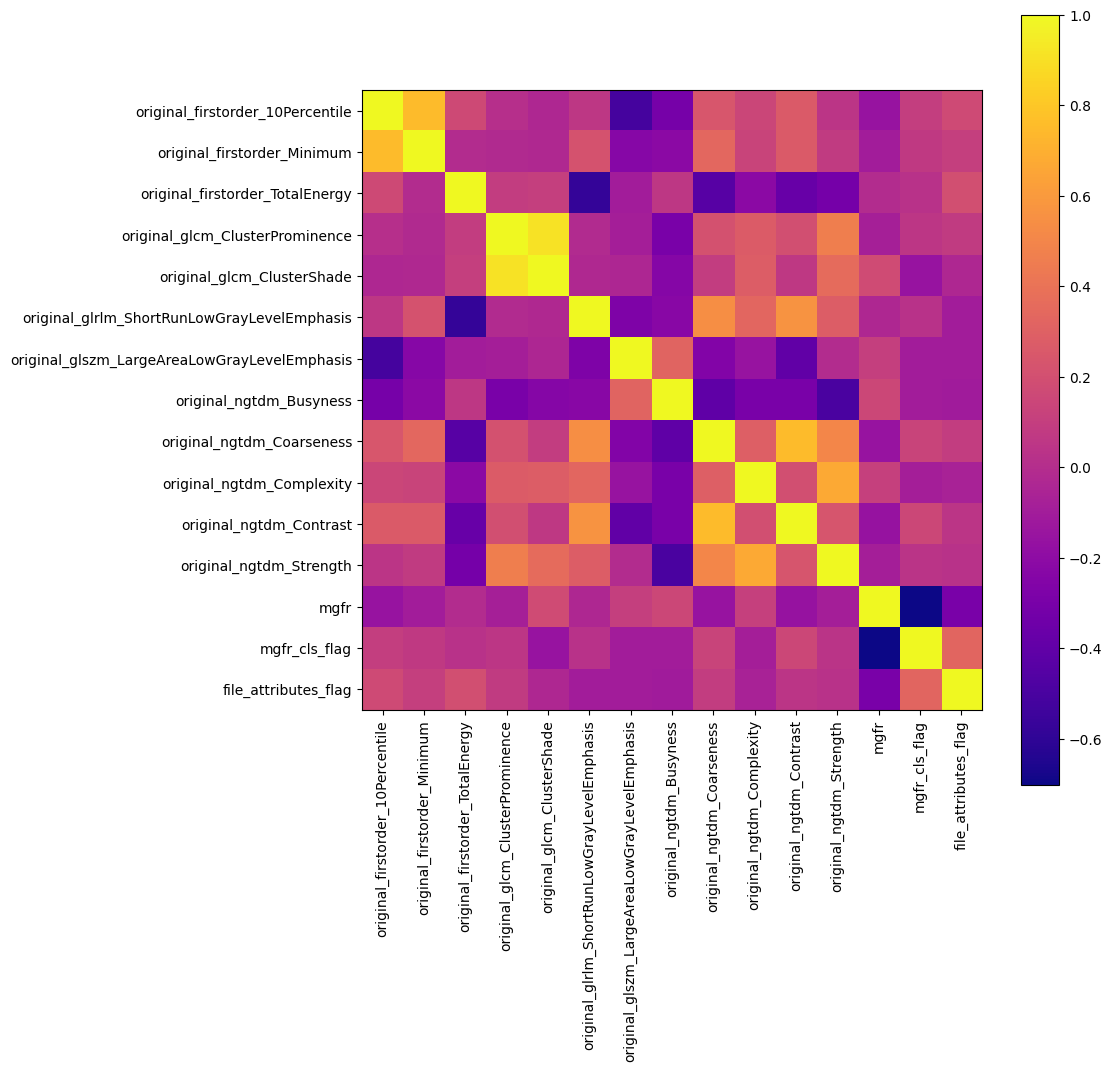

In [41]:
# plotting correlation ratios for visualization:
corrMatrix= data_processed_no_id.corr()
print('Correlation Heatmap')
fig, ax = plt.subplots(figsize=[10,10])
im = ax.imshow(corrMatrix, cmap='plasma')
ax.set_xticks(np.arange(len(corrMatrix)))
ax.set_yticks(np.arange(len(corrMatrix)))
ax.set_xticklabels(corrMatrix.columns)
ax.set_yticklabels(corrMatrix.columns)
plt.xticks(rotation='vertical')
plt.colorbar(im)
plt.savefig('corrMatrix.png')
corrMatrix.to_csv('corrMatrix.csv', index = False)


# Machine Learning Section

In [27]:
#SKlearn models
#arguments are compilation of all possible hyperparams
def fit_model(xTrain,yTrain, xTest, yTest, model_name, max_depth_RF = 5, min_samples = 5,
          min_split = 5, num_trees = 20, n_sample =100, max_iter = 500, 
            kernel = 'linear', max_depth_DT = 4, 
            iter_cb = 100, lr_cb = 0.2, random_state = 42):
    
    if(model_name == "RF"):
        model = RandomForestClassifier(class_weight='balanced', n_jobs = -1,
                                   warm_start = True, max_depth = max_depth_RF, 
                                   min_samples_leaf = min_samples,
                                   min_samples_split = min_split, 
                                   n_estimators = num_trees)
        model.fit(xTrain, yTrain) 
        imps = model.feature_importances_
        
    elif(model_name == "SVM"):
        model = svm.SVC(kernel = kernel, probability= True, decision_function_shape = 'ovr')
        model.fit(xTrain, yTrain) 
        # perform permutation importance
        imps_temp = permutation_importance(model, xTrain, yTrain, 
                                      scoring='neg_mean_squared_error')
        # get importance
        imps = imps_temp.importances_mean

    elif(model_name == "NN"):
        model = MLPClassifier(random_state=random_state, max_iter=max_iter,alpha=1e-06, hidden_layer_sizes=(5, 2),
              solver='lbfgs')
        #there is no inherent feature importance algorithm for a NN
        (row,col) = xTrain.shape
        model.fit(xTrain, yTrain) 
        imps = np.zeros(col)
        
    elif(model_name == "DT"):
        model = DecisionTreeClassifier(max_depth=max_depth_DT,random_state=random_state)
        #for some reason the DT classifier needs to be fitted before
        #extracting feature importances
        model.fit(xTrain, yTrain)
        imps = model.feature_importances_
        feature_names = xTrain.columns
        graph = Source(export_graphviz(model, out_file='tree.dot', 
                                       class_names=['Normal','Indeterminate','Grade II', 'Grade III'], 
                                       feature_names=feature_names, impurity=False, filled=True))
    elif(model_name == "catboost"):
        model = CatBoostClassifier(iterations = 100,
                                 random_seed = 32,
                                 learning_rate = 0.5)
        #catboost has it's own weird fit function arguments
        model.fit(xTrain, yTrain, eval_set = (xTest, yTest), silent = True)
        preds = model.predict(xTest)
        imps = model.get_feature_importance(type='PredictionValuesChange', 
                                                prettified = False)    
        
    preds = model.predict(xTest)
    preds_proba = model.predict_proba(xTest)
    
    return model, preds, preds_proba, imps

    

In [28]:
def train_classifier(data_input, model_name = 'RF', outcome_name = "mgfr_cls_flag", k = 5,
                     all_outcome_labels = ['file_attributes_flag', 'mgfr', 'mgfr_cls_flag'],
                     max_depth_RF = 5, min_samples = 5,
                    min_split = 5, num_trees = 20, n_sample =100, max_iter = 300, 
                    kernel = 'linear', max_depth_DT = 4, 
                    iter_cb = 100, lr_cb = 0.5, random_state = 42):
    
    sens = []
    spec = []
    acc = []
    # have to name auc aucVal beacuse auc is the library name
    auc_val = []
    imps_list = []
    i = 1
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6,3.75))
    
    outcome = data_input[outcome_name].astype(int)
    data_without_outcome = data_input.drop(columns=[col for col in all_outcome_labels if col in data_input.columns])

    
    kf=StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

    for trainIdx, testIdx in kf.split(data_without_outcome,outcome):
        print("Model: " + model_name + ", K-fold: " + str(i))
        xTrain, xTest = data_without_outcome.iloc[trainIdx], data_without_outcome.iloc[testIdx]
        yTrain, yTest = outcome.iloc[trainIdx], outcome.iloc[testIdx]
        #building model based on input

        model, preds, preds_proba, imp = fit_model(xTrain, yTrain, 
                                                  xTest, yTest, model_name, 
                                                   max_depth_DT = max_depth_DT)

        imps_list.append(imp)
        
        #appending to validation metrics for this k-fold
        cm = confusion_matrix(yTest, preds, labels = model.classes_)
        #disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        #                               display_labels=model.classes_)
        #fig_cm, ax_cm = plt.subplots()
        #disp.plot(ax=ax_cm)
        #plt.show()
        #plt.close(fig_cm)
        
        #metrics
        tp = np.sum(np.diag(cm))
        fp = np.sum(cm.sum(axis=0)) - tp
        fn = np.sum(cm.sum(axis=1)) - tp
        tn = np.sum(cm.sum()) - (fp + fn + tp)

        spec.append(tn/(tn+fp))
        sens.append(tp/(tp+fn))
        acc.append((tp+tn)/(tp+tn+fp+fn))

        #computing and displaying AUC
        auc_val.append(roc_auc_score(yTest, preds))
        
        plt.figure(fig.number) 
        viz = RocCurveDisplay.from_estimator(model, xTest, yTest, 
                                             name="ROC fold {}".format(i), alpha=0.5, lw=1, ax=ax,)
    
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        i = i+1
        
    #plotting all AUCs
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr,mean_tpr,color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,alpha=0.8,)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr,tprs_lower, tprs_upper,color="grey",
                    alpha=0.2,label=r"$\pm$ 1 std. dev.",)

    ax.set(xlim=[-0.05, 1.05],ylim=[-0.05, 1.05],)
    ax.legend(loc="lower right")
    plt.show()
        
    return sens, spec, acc, auc_val, imps_list, preds_proba

Model: RF, K-fold: 1
Model: RF, K-fold: 2
Model: RF, K-fold: 3
Model: RF, K-fold: 4
Model: RF, K-fold: 5


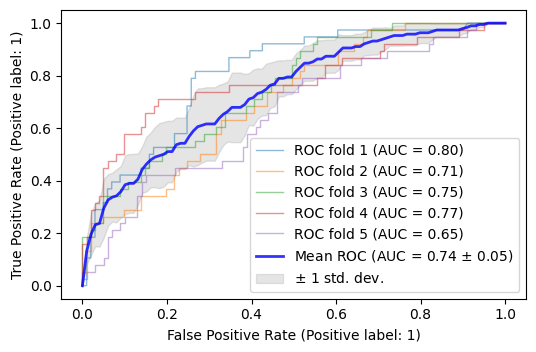

Model: DT, K-fold: 1
Model: DT, K-fold: 2
Model: DT, K-fold: 3
Model: DT, K-fold: 4
Model: DT, K-fold: 5


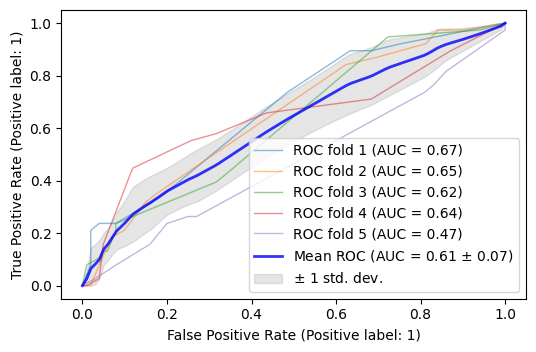

Model: catboost, K-fold: 1
Model: catboost, K-fold: 2
Model: catboost, K-fold: 3
Model: catboost, K-fold: 4
Model: catboost, K-fold: 5


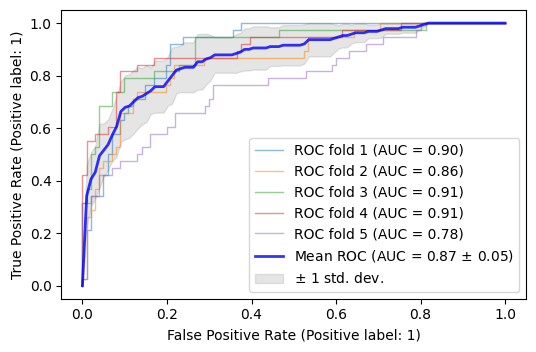

Model: NN, K-fold: 1
Model: NN, K-fold: 2
Model: NN, K-fold: 3
Model: NN, K-fold: 4
Model: NN, K-fold: 5


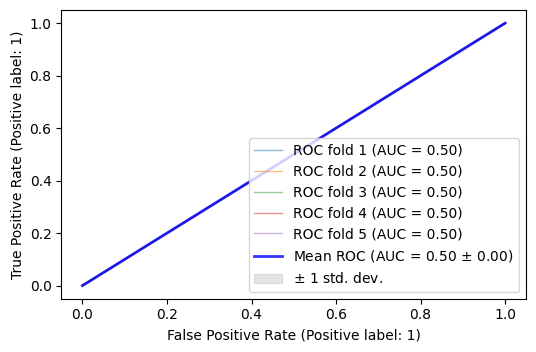

In [46]:
sens_RF, spec_RF, acc_RF, auc_val_RF, imps_RF, preds_proba_RF = train_classifier(data_processed_no_id,
                                                                                 model_name = 'RF', 
                                                                                 outcome_name ="mgfr_cls_flag",
                                                                                 k = 5, max_depth_RF = 10, 
                                                                                 min_samples = 5, min_split = 5,
                                                                                 num_trees = 100,
                                                                                all_outcome_labels = ['file_attributes_flag', 'mgfr', 'mgfr_cls_flag'])

sens_DT, spec_DT, acc_DT, auc_val_DT, imps_DT, preds_proba_DT = train_classifier(data_processed_no_id,
                                                                                 model_name = 'DT', 
                                                                                 outcome_name ="mgfr_cls_flag",
                                                                                 k = 5, max_depth_RF = 10, 
                                                                                 min_samples = 5, min_split = 5,
                                                                                 num_trees = 100,
                                                                                all_outcome_labels = ['file_attributes_flag', 'mgfr', 'mgfr_cls_flag'])

sens_CB, spec_CB, acc_CB, auc_val_CB, imps_CB, preds_proba_CB= train_classifier(data_processed_no_id,
                                                                                 model_name = 'catboost', 
                                                                                 outcome_name ="mgfr_cls_flag",
                                                                                 k = 5, max_depth_RF = 10, 
                                                                                 min_samples = 5, min_split = 5,
                                                                                 num_trees = 100,
                                                                                all_outcome_labels = ['file_attributes_flag', 'mgfr', 'mgfr_cls_flag'])

sens_NN, spec_NN, acc_NN, auc_val_NN, imps_NN, preds_proba_NN = train_classifier(data_processed_no_id,
                                                                                 model_name = 'NN', 
                                                                                 outcome_name ="mgfr_cls_flag",
                                                                                 k = 5, max_depth_RF = 10, 
                                                                                 min_samples = 5, min_split = 5,
                                                                                 num_trees = 100,
                                                                                all_outcome_labels = ['file_attributes_flag', 'mgfr', 'mgfr_cls_flag'])


In [54]:
#displaying results
def display_results(model_name,sens,spec,acc,auc_val,imps,preds_proba, feature_names):

    print("Model: " + model_name)

    #defining column names
    results_cols = ["Sens", "Spec", "Acc", "AUC"]

    #converting results and feature importances to dataframes, then computing
    #the average and also confidence interval
    results = pd.DataFrame(data=np.column_stack((sens,spec, acc,auc_val)), 
                           index=None, columns=results_cols)

    results_temp = pd.DataFrame(data=results, index=None, columns=results_cols)
    results_df = pd.concat([results_temp, results_temp.mean().to_frame('Average').T])
    results_df = pd.concat([results_df, results_temp.std().to_frame(u"\u00B1").T])

    imps_temp= pd.DataFrame(data=imps, index=None, columns=feature_names)
    imps_df = pd.concat([imps_temp, imps_temp.mean().to_frame('Average').T])
    imps_df = pd.concat([imps_df, imps_temp.std().to_frame(u"\u00B1").T])

    display(results_df)
    display(imps_df)

    # Extract values
    averages = imps_df.loc["Average"]
    errors = imps_df.loc[u"\u00B1"]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(averages.index, averages.values, yerr=errors.values, capsize=5)
    plt.ylabel("Value")
    plt.title("Bar Chart with Uncertainty (±)")
    plt.xticks(rotation=90)
    plt.title("Feature Importances")
    plt.show()

Model: RF


Sens  Spec       Acc       AUC
0        0.741007  -inf  0.482014  0.665842
1        0.683453  -inf  0.366906  0.601615
2        0.733813  -inf  0.467626  0.652684
3        0.762590  -inf  0.525180  0.746352
4        0.644928  -inf  0.289855  0.583684
Average  0.713158  -inf  0.426316  0.650035
±        0.047915   NaN  0.095831  0.063798

original_firstorder_10Percentile  original_firstorder_Minimum  \
0                                0.054040                     0.028744   
1                                0.054477                     0.014036   
2                                0.056801                     0.017565   
3                                0.036053                     0.004048   
4                                0.049643                     0.013327   
Average                          0.050203                     0.015544   
±                                0.008323                     0.008912   

         original_firstorder_TotalEnergy  original_glcm_ClusterProminence  \
0                               0.054912                         0.093788   
1                               0.043104                         0.125223   
2                               0.061619                         0.083975   
3                               0.064628                         0.096794   
4                               0.059183                         0.088431   
Average                         0.056689                         0.097642   
±                               0.008385                         0.016186   

         original_glcm_ClusterShade  \
0                          0.140233   
1                          0.167292   
2                          0.097280   
3                          0.185879   
4                          0.147644   
Average                    0.147666   
±                          0.033315   

         original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                           0.081518   
1                                           0.046083   
2                                           0.054803   
3                                           0.068039   
4                                           0.077412   
Average                                     0.065571   
±                                           0.014970   

         original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                            0.074916   
1                                            0.056775   
2                                            0.114610   
3                                            0.046361   
4                                            0.074734   
Average                                      0.073479   
±                                            0.026028   

         original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0                       0.084518                   0.055721   
1                       0.125250                   0.084200   
2                       0.128259                   0.089972   
3                       0.122961                   0.088717   
4                       0.102277                   0.086621   
Average                 0.112653                   0.081046   
±                       0.018760                   0.014326   

         original_ngtdm_Complexity  original_ngtdm_Contrast  \
0                         0.162927                 0.056680   
1                         0.163666                 0.048426   
2                         0.190231                 0.042603   
3                         0.121663                 0.073505   
4                         0.133036                 0.089614   
Average                   0.154305                 0.062166   
±                         0.027251                 0.019258   

         original_ngtdm_Strength  
0                       0.112003  
1                       0.071467  
2                       0.062282  
3                       0.091354  
4                       0.078077  
Average                 0.083037  
±                       0.019348

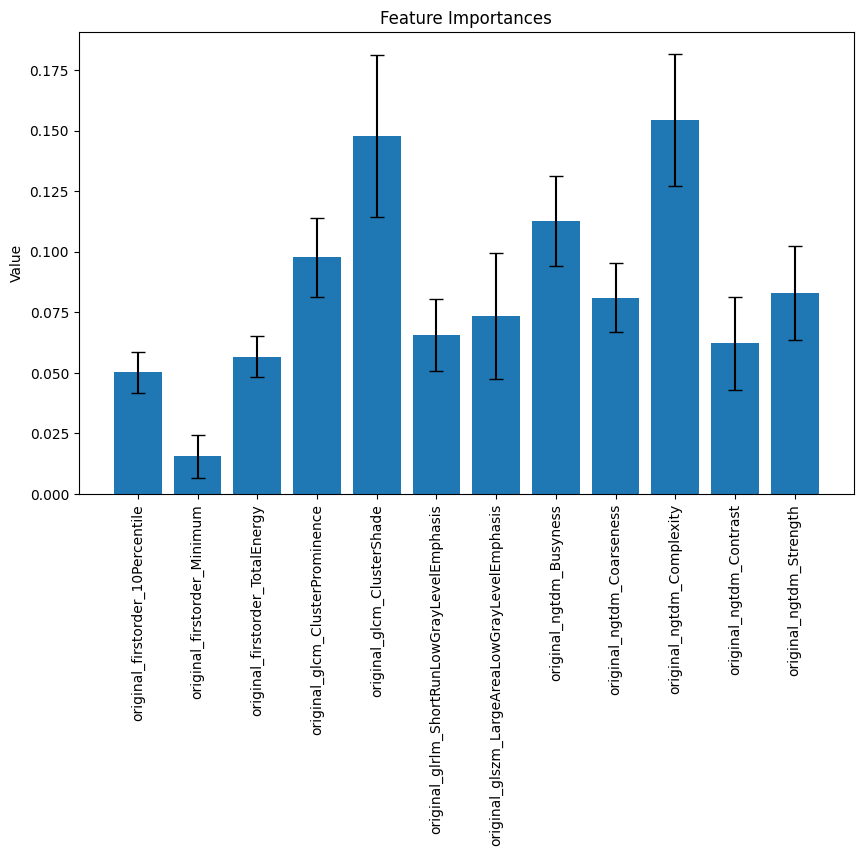

Model: DT


Sens  Spec       Acc       AUC
0        0.762590  -inf  0.525180  0.598619
1        0.705036  -inf  0.410072  0.583637
2        0.726619  -inf  0.453237  0.565659
3        0.733813  -inf  0.467626  0.554195
4        0.644928  -inf  0.289855  0.518421
Average  0.714597  -inf  0.429194  0.564106
±        0.044052   NaN  0.088104  0.030661

original_firstorder_10Percentile  original_firstorder_Minimum  \
0                                0.000000                          0.0   
1                                0.000000                          0.0   
2                                0.032146                          0.0   
3                                0.000000                          0.0   
4                                0.000000                          0.0   
Average                          0.006429                          0.0   
±                                0.014376                          0.0   

         original_firstorder_TotalEnergy  original_glcm_ClusterProminence  \
0                               0.000000                         0.094100   
1                               0.103656                         0.090475   
2                               0.000000                         0.222515   
3                               0.000000                         0.127211   
4                               0.000000                         0.146207   
Average                         0.020731                         0.136102   
±                               0.046356                         0.053606   

         original_glcm_ClusterShade  \
0                          0.230998   
1                          0.111342   
2                          0.207980   
3                          0.079140   
4                          0.195615   
Average                    0.165015   
±                          0.065938   

         original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                           0.064483   
1                                           0.000000   
2                                           0.000000   
3                                           0.000000   
4                                           0.155147   
Average                                     0.043926   
±                                           0.068156   

         original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                            0.000000   
1                                            0.108858   
2                                            0.218683   
3                                            0.023041   
4                                            0.089964   
Average                                      0.088109   
±                                            0.085850   

         original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0                       0.116141                   0.000000   
1                       0.104828                   0.018824   
2                       0.095535                   0.000000   
3                       0.123274                   0.000000   
4                       0.000000                   0.148751   
Average                 0.087956                   0.033515   
±                       0.050299                   0.064933   

         original_ngtdm_Complexity  original_ngtdm_Contrast  \
0                         0.220079                 0.031133   
1                         0.162675                 0.021348   
2                         0.218181                 0.004959   
3                         0.271269                 0.000000   
4                         0.136506                 0.000000   
Average                   0.201742                 0.011488   
±                         0.052968                 0.014051   

         original_ngtdm_Strength  
0                       0.243067  
1                       0.277994  
2                       0.000000  
3                       0.376066  
4                       0.127811  
Average                 0.204987  
±                       0.144934

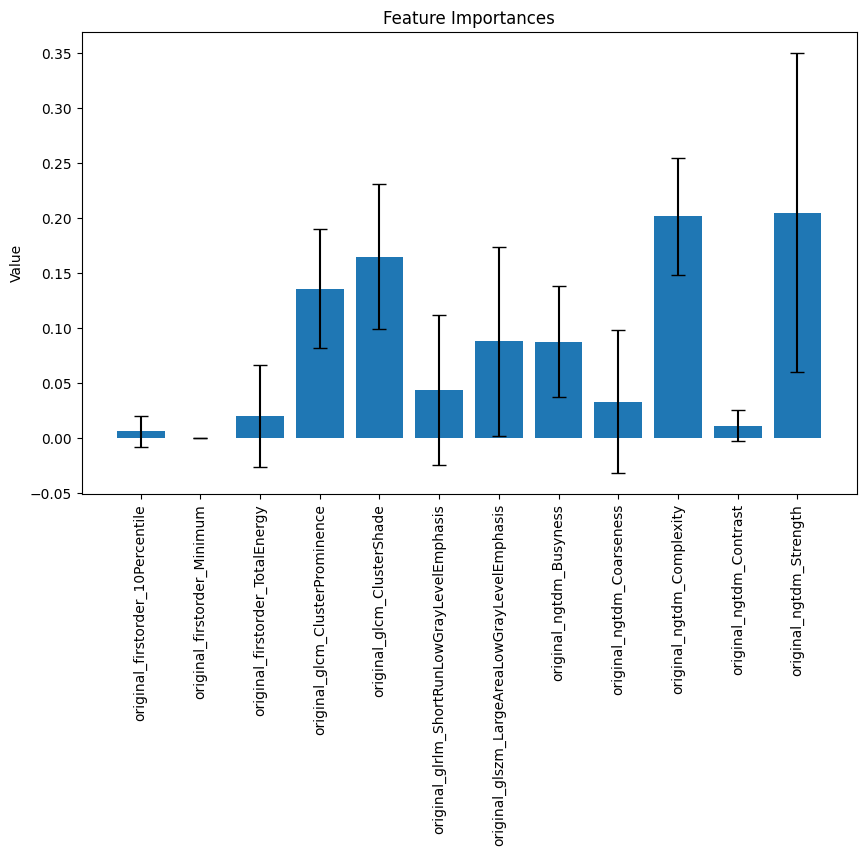

Model: NN


Sens  Spec       Acc  AUC
0        0.726619  -inf  0.453237  0.5
1        0.726619  -inf  0.453237  0.5
2        0.726619  -inf  0.453237  0.5
3        0.726619  -inf  0.453237  0.5
4        0.724638  -inf  0.449275  0.5
Average  0.726223  -inf  0.452445  0.5
±        0.000886   NaN  0.001772  0.0

original_firstorder_10Percentile  original_firstorder_Minimum  \
0                                0.054040                     0.028744   
1                                0.054477                     0.014036   
2                                0.056801                     0.017565   
3                                0.036053                     0.004048   
4                                0.049643                     0.013327   
Average                          0.050203                     0.015544   
±                                0.008323                     0.008912   

         original_firstorder_TotalEnergy  original_glcm_ClusterProminence  \
0                               0.054912                         0.093788   
1                               0.043104                         0.125223   
2                               0.061619                         0.083975   
3                               0.064628                         0.096794   
4                               0.059183                         0.088431   
Average                         0.056689                         0.097642   
±                               0.008385                         0.016186   

         original_glcm_ClusterShade  \
0                          0.140233   
1                          0.167292   
2                          0.097280   
3                          0.185879   
4                          0.147644   
Average                    0.147666   
±                          0.033315   

         original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                           0.081518   
1                                           0.046083   
2                                           0.054803   
3                                           0.068039   
4                                           0.077412   
Average                                     0.065571   
±                                           0.014970   

         original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                            0.074916   
1                                            0.056775   
2                                            0.114610   
3                                            0.046361   
4                                            0.074734   
Average                                      0.073479   
±                                            0.026028   

         original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0                       0.084518                   0.055721   
1                       0.125250                   0.084200   
2                       0.128259                   0.089972   
3                       0.122961                   0.088717   
4                       0.102277                   0.086621   
Average                 0.112653                   0.081046   
±                       0.018760                   0.014326   

         original_ngtdm_Complexity  original_ngtdm_Contrast  \
0                         0.162927                 0.056680   
1                         0.163666                 0.048426   
2                         0.190231                 0.042603   
3                         0.121663                 0.073505   
4                         0.133036                 0.089614   
Average                   0.154305                 0.062166   
±                         0.027251                 0.019258   

         original_ngtdm_Strength  
0                       0.112003  
1                       0.071467  
2                       0.062282  
3                       0.091354  
4                       0.078077  
Average                 0.083037  
±                       0.019348

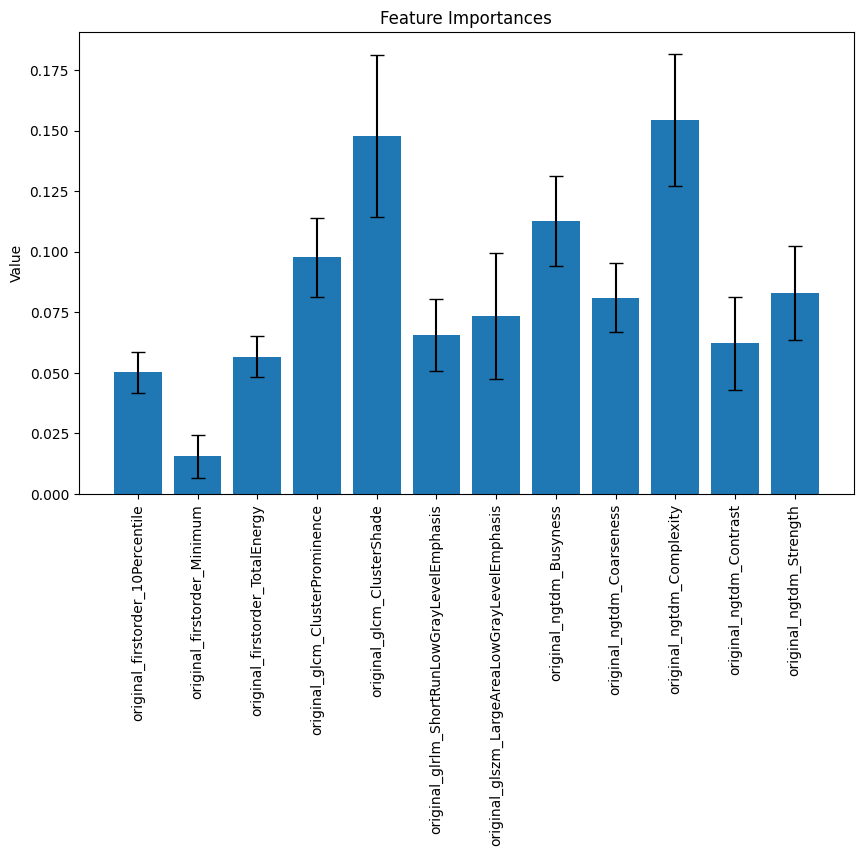

Model: CB


Sens  Spec       Acc       AUC
0        0.805755  -inf  0.611511  0.693981
1        0.812950  -inf  0.625899  0.715347
2        0.848921  -inf  0.697842  0.756514
3        0.863309  -inf  0.726619  0.766415
4        0.797101  -inf  0.594203  0.688684
Average  0.825607  -inf  0.651215  0.724188
±        0.028861   NaN  0.057722  0.035634

original_firstorder_10Percentile  original_firstorder_Minimum  \
0                                2.308964                     0.440398   
1                                2.539769                     0.910678   
2                                4.362687                     2.331125   
3                                2.813098                     1.362445   
4                                4.011196                     1.141242   
Average                          3.207143                     1.237177   
±                                0.920485                     0.700549   

         original_firstorder_TotalEnergy  original_glcm_ClusterProminence  \
0                               4.265437                        17.938370   
1                               3.424962                        16.362741   
2                               4.146751                        13.831380   
3                               3.925928                        15.925660   
4                               4.052306                        15.750945   
Average                         3.963077                        15.961819   
±                               0.325602                         1.470717   

         original_glcm_ClusterShade  \
0                         19.202185   
1                         20.700918   
2                         17.187284   
3                         21.939412   
4                         25.112919   
Average                   20.828543   
±                          2.979513   

         original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                           2.181704   
1                                           2.593689   
2                                           2.378458   
3                                           3.079991   
4                                           1.719620   
Average                                     2.390693   
±                                           0.502619   

         original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                            2.148111   
1                                            4.158707   
2                                            3.780106   
3                                            3.355109   
4                                            3.551851   
Average                                      3.398777   
±                                            0.760330   

         original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0                       5.120839                   3.906873   
1                       6.473682                   3.884389   
2                       6.002195                   3.472611   
3                       5.163444                   4.400248   
4                       4.450284                   3.631991   
Average                 5.442089                   3.859222   
±                       0.797249                   0.352390   

         original_ngtdm_Complexity  original_ngtdm_Contrast  \
0                        16.997756                 6.304326   
1                        14.574122                 3.493922   
2                        16.362888                 7.086324   
3                        15.343777                 4.074334   
4                        12.273581                 3.454012   
Average                  15.110425                 4.882584   
±                         1.838508                 1.695604   

         original_ngtdm_Strength  
0                      19.185037  
1                      20.882422  
2                      19.058193  
3                      18.616554  
4                      20.850053  
Average                19.718452  
±                       1.068878

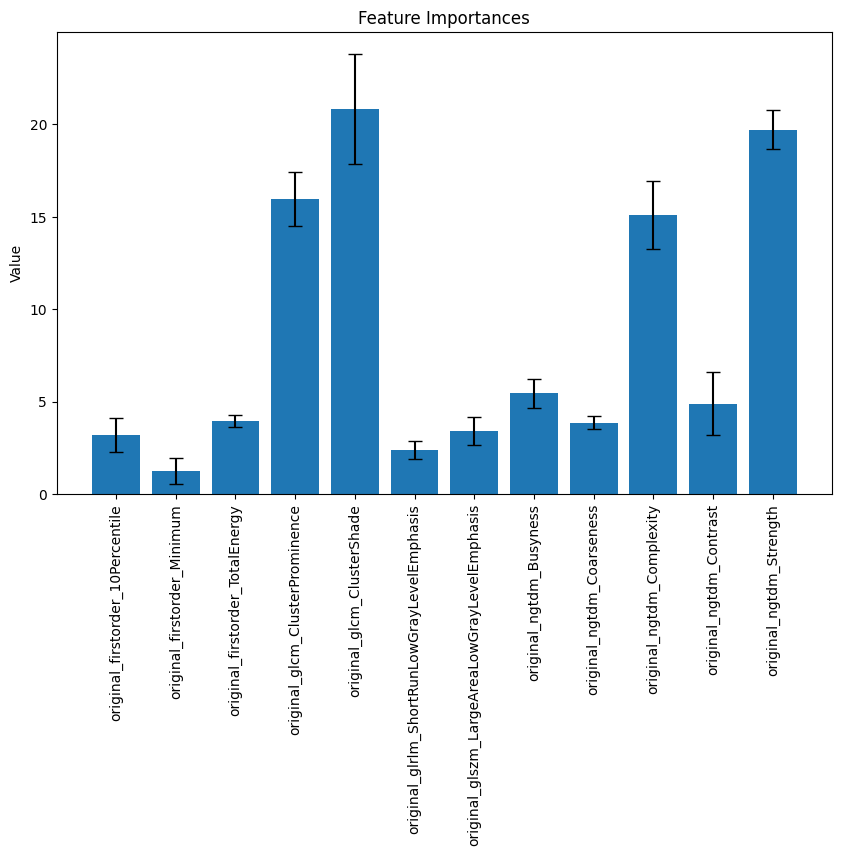

In [55]:
feature_names = data_processed_no_id.drop(columns = ['mgfr','mgfr_cls_flag','file_attributes_flag']).columns.tolist()
display_results('RF', sens_RF, spec_RF, acc_RF, auc_val_RF,imps_RF,preds_proba_RF,feature_names)
display_results('DT', sens_DT, spec_DT, acc_DT, auc_val_DT,imps_DT,preds_proba_DT,feature_names)
display_results('NN', sens_NN, spec_NN, acc_NN, auc_val_NN,imps_RF,preds_proba_NN,feature_names)
display_results('CB', sens_CB, spec_CB, acc_CB, auc_val_CB,imps_CB,preds_proba_CB,feature_names)

In [14]:
from pycaret.classification import *
clf = setup(data=data_processed_no_id.drop(columns = ['file_attributes_flag', 'mgfr']), 
                                           target='mgfr_cls_flag')
best_model = compare_models()